# Cats vs Dogs - Image Classification Using CNN

Este trabalho tem como sua base o terceiro capítulo do livro [Neural Network Projects with Python](https://www.amazon.com.br/Neural-Network-Projects-Python-James/dp/1789138906). Neste capítulo o autor usa o James Loy mostra como usar a biblioteca [Keras](https://keras.io/) para criar uma Convolution Neural Network com intuito de classificar se um animal é um gato ou um cachorro do dataset [Cats and Dogs](https://www.microsoft.com/en-us/download/details.aspx?id=54765).

Neste notebook você podera encontrar algumas diferenças do encontrado no livro ou mesmo no [repósitorio](https://github.com/PacktPublishing/Neural-Network-Projects-with-Python/tree/master/Chapter04) do livro do autor, como por exemplo a parte de análise exploratória um pouco mais extensa, feature engineering e otimização da rede neural criada para resolver o problema de classificação do dataset.

In [1]:
# Manipulação de Dados
import numpy as np
import pandas as pd
import random

# Visualização de Dados
import matplotlib.pyplot as plt

# Preprocessing
from keras.preprocessing.image import ImageDataGenerator

# Deep Learning
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception

# Sistema Operacional
import os
import shutil
import piexif

In [2]:
# Obtendo a lista com os nomes dos arquivos
_, _, cat_images = next(os.walk('Data/catsanddogs/PetImages/Cat'))

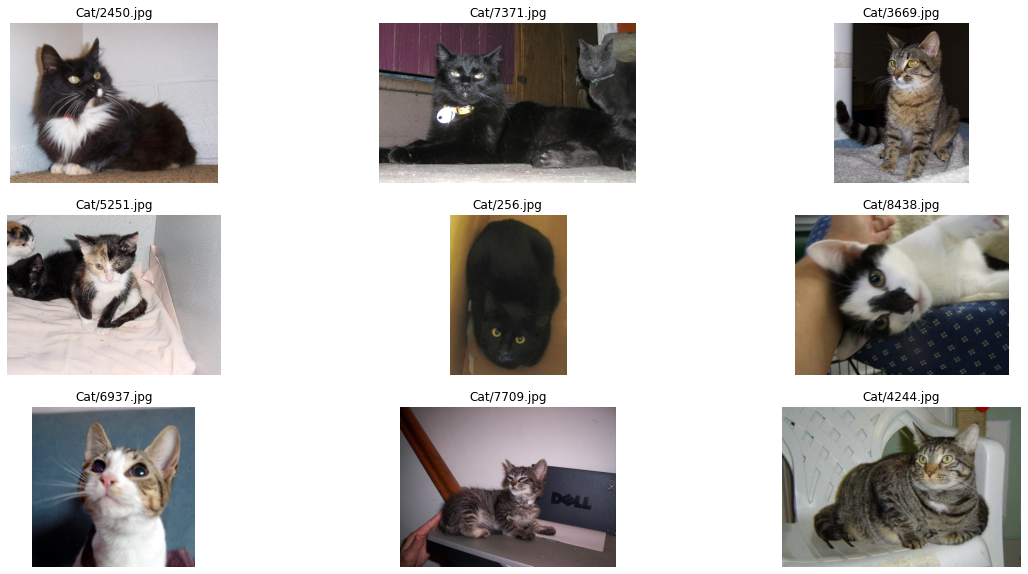

In [3]:
# Plot com 9 imagens de gatos
fig, ax = plt.subplots(3,3, figsize=(20,10))

# Selecionando as imagens aleatóriamente
for idx, img in enumerate(random.sample(cat_images, 9)):
    img_read = plt.imread('Data/catsanddogs/PetImages/Cat/'+img)
    ax[int(idx/3), idx%3].imshow(img_read)
    ax[int(idx/3), idx%3].axis('off')
    ax[int(idx/3), idx%3].set_title('Cat/'+img)

plt.show()

In [4]:
# Obtendo a lista com os nomes dos arquivos
_, _, dog_images = next(os.walk('Data/catsanddogs/PetImages/Dog'))

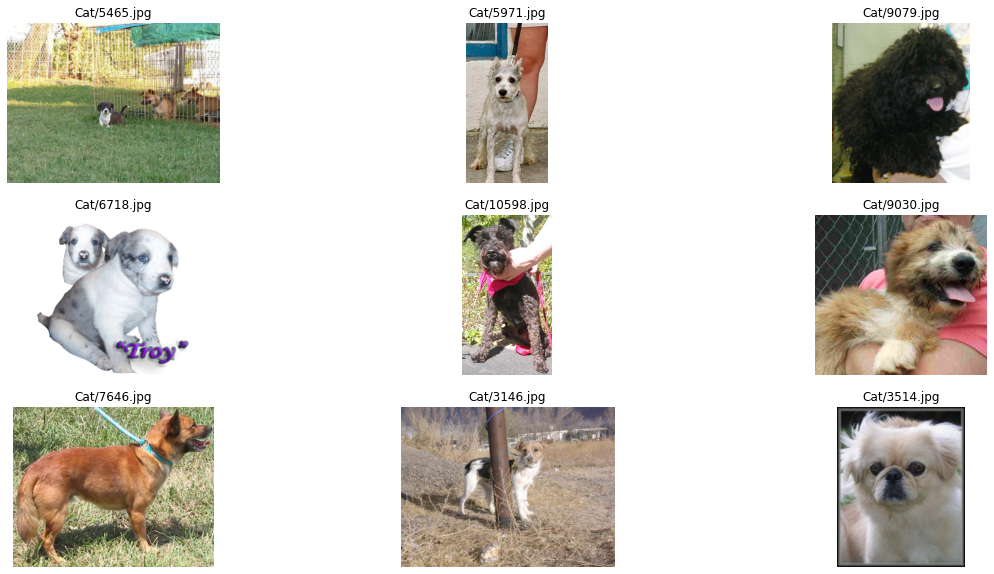

In [5]:
# Plot com 9 imagens de cachorros
fig, ax = plt.subplots(3,3, figsize=(20,10))

# Selecionando as imagens aleatóriamente
for idx, img in enumerate(random.sample(dog_images, 9)):
    img_read = plt.imread('Data/catsanddogs/PetImages/Dog/'+img)
    ax[int(idx/3), idx%3].imshow(img_read)
    ax[int(idx/3), idx%3].axis('off')
    ax[int(idx/3), idx%3].set_title('Cat/'+img)

plt.show()

In [6]:
# Função para dividir em treino e teste
def train_test_split(src_folder, train_size = 0.8):
    # Certifique-se de remover todas as pastas existentes e começar de uma forma limpa
    shutil.rmtree(src_folder+'Train/Cat/', ignore_errors=True)
    shutil.rmtree(src_folder+'Train/Dog/', ignore_errors=True)
    shutil.rmtree(src_folder+'Test/Cat/', ignore_errors=True)
    shutil.rmtree(src_folder+'Test/Dog/', ignore_errors=True)

    # Agora, crie novas pastas vazias de trem e teste
    os.makedirs(src_folder+'Train/Cat/')
    os.makedirs(src_folder+'Train/Dog/')
    os.makedirs(src_folder+'Test/Cat/')
    os.makedirs(src_folder+'Test/Dog/')

    # Obter o número de imagens de cães e gatos
    _, _, cat_images = next(os.walk(src_folder+'Cat/'))
    files_to_be_removed = ['Thumbs.db', '666.jpg', '835.jpg']
    for file in files_to_be_removed:
        cat_images.remove(file)
    num_cat_images = len(cat_images)
    num_cat_images_train = int(train_size * num_cat_images)
    num_cat_images_test = num_cat_images - num_cat_images_train

    _, _, dog_images = next(os.walk(src_folder+'Dog/'))
    files_to_be_removed = ['Thumbs.db', '11702.jpg']
    for file in files_to_be_removed:
        dog_images.remove(file)
    num_dog_images = len(dog_images)
    num_dog_images_train = int(train_size * num_dog_images)
    num_dog_images_test = num_dog_images - num_dog_images_train

    # Atribuir imagens aleatoriamente para treinar e testar
    cat_train_images = random.sample(cat_images, num_cat_images_train)
    for img in cat_train_images:
        shutil.copy(src=src_folder+'Cat/'+img, dst=src_folder+'Train/Cat/')
    cat_test_images  = [img for img in cat_images if img not in cat_train_images]
    for img in cat_test_images:
        shutil.copy(src=src_folder+'Cat/'+img, dst=src_folder+'Test/Cat/')

    dog_train_images = random.sample(dog_images, num_dog_images_train)
    for img in dog_train_images:
        shutil.copy(src=src_folder+'Dog/'+img, dst=src_folder+'Train/Dog/')
    dog_test_images  = [img for img in dog_images if img not in dog_train_images]
    for img in dog_test_images:
        shutil.copy(src=src_folder+'Dog/'+img, dst=src_folder+'Test/Dog/')

    # remover dados exif corrompidos do conjunto de dados
    remove_exif_data(src_folder+'Train/')
    remove_exif_data(src_folder+'Test/')

# função auxiliar para remover dados exif corrompidos do conjunto de dados da Microsoft
def remove_exif_data(src_folder):
    _, _, cat_images = next(os.walk(src_folder+'Cat/'))
    for img in cat_images:
        try:
            piexif.remove(src_folder+'Cat/'+img)
        except:
            pass

    _, _, dog_images = next(os.walk(src_folder+'Dog/'))
    for img in dog_images:
        try:
            piexif.remove(src_folder+'Dog/'+img)
        except:
            pass

In [7]:
# Divisão de treino e teste
src_folder = 'Data/catsanddogs/PetImages/'
train_test_split(src_folder)

In [8]:
# Image Augmentation
image_generator = ImageDataGenerator(rotation_range = 30,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

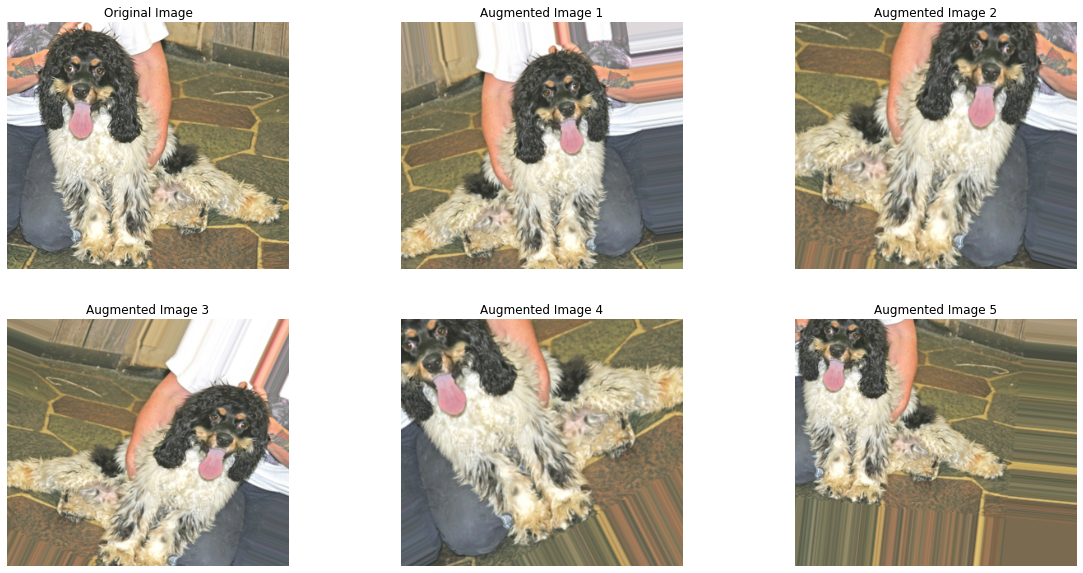

In [9]:
# Checando a Image Augmentation
fig, ax = plt.subplots(2,3, figsize=(20,10))
all_images = []

_, _, dog_images = next(os.walk('Data/catsanddogs/PetImages/Train/Dog/'))
random_img = random.sample(dog_images, 1)[0]
random_img = plt.imread('Data/catsanddogs/PetImages/Train/Dog/'+random_img)
all_images.append(random_img)

random_img = random_img.reshape((1,) + random_img.shape)
sample_augmented_images = image_generator.flow(random_img)

for _ in range(5):
    augmented_imgs = sample_augmented_images.next()
    for img in augmented_imgs:
        all_images.append(img.astype('uint8'))

for idx, img in enumerate(all_images):
    ax[int(idx/3), idx%3].imshow(img)
    ax[int(idx/3), idx%3].axis('off')
    if idx == 0:
        ax[int(idx/3), idx%3].set_title('Original Image')
    else:
        ax[int(idx/3), idx%3].set_title('Augmented Image {}'.format(idx))

plt.show()

# Building a Simple CNN

In [10]:
# Instância o modelo
model_cnn = Sequential()

# Hiperparâmetros
FILTER_SIZE = 3
NUM_FILTERS = 32
INPUT_SIZE  = 32
MAXPOOL_SIZE = 2
BATCH_SIZE = 16
STEPS_PER_EPOCH = 20000//BATCH_SIZE
EPOCHS = 10

# Convolution Layer
model_cnn.add(Conv2D(NUM_FILTERS, (FILTER_SIZE, FILTER_SIZE), 
                     input_shape=(INPUT_SIZE, INPUT_SIZE, 3),
                     activation='relu'))
# Max-Pooling Layer
model_cnn.add(MaxPooling2D(pool_size=(MAXPOOL_SIZE, MAXPOOL_SIZE)))
# Convolution Layer
model_cnn.add(Conv2D(NUM_FILTERS, (FILTER_SIZE, FILTER_SIZE), 
                     input_shape=(INPUT_SIZE, INPUT_SIZE, 3),
                     activation='relu'))
# Max-Pooling Layer
model_cnn.add(MaxPooling2D(pool_size=(MAXPOOL_SIZE, MAXPOOL_SIZE)))
# Flatten Node
model_cnn.add(Flatten())
# Fully Connect Layers
model_cnn.add(Dense(units=128, activation='relu'))
# Dropout: Set 50% of the weights to 0
model_cnn.add(Dropout(0.5))
# Saída
model_cnn.add(Dense(units=1, activation='sigmoid'))

# Compilando o modelo
model_cnn.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

In [11]:
training_data_generator = ImageDataGenerator(rescale=1./255)

training_set = training_set = training_data_generator.flow_from_directory('Data/catsanddogs/PetImages/Train',
                                                                          target_size=(INPUT_SIZE,INPUT_SIZE), 
                                                                          batch_size=BATCH_SIZE, 
                                                                          class_mode='binary')

model_cnn.fit_generator(training_set, 
                        steps_per_epoch=STEPS_PER_EPOCH, 
                        epochs=EPOCHS, 
                        verbose=1)

Found 19997 images belonging to 2 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
1250/1250 [==============================] - 91s 73ms/step - loss: 0.6310 - accuracy: 0.6367
Epoch 2/10
1250/1250 [==============================] - 86s 69ms/step - loss: 0.5389 - accuracy: 0.7288
Epoch 3/10
1250/1250 [==============================] - 86s 69ms/step - loss: 0.4947 - accuracy: 0.7606
Epoch 4/10
1250/1250 [==============================] - 86s 69ms/step - loss: 0.4572 - accuracy: 0.7862
Epoch 5/10
1250/1250 [==============================] - 85s 68ms/step - loss: 0.4322 - accuracy: 0.7998
Epoch 6/10
1250/1250 [==============================] - 85s 68ms/step - loss: 0.4053 - accuracy: 0.8135
Epoch 7/10
1250/1250 [==============================] - 85s 68ms/step - loss: 0.3825 - accuracy: 0.8264
Epoch 8/10
1250/1250 [==============================] - 86s 69ms/step - loss: 0.3541 - accuracy: 0.8406
Epoch 9/10
1250/1250 [===========================

In [12]:
testing_data_generator = ImageDataGenerator(rescale = 1./255)

test_set = testing_data_generator.flow_from_directory('Data/catsanddogs/PetImages/Test',
                                                      target_size=(INPUT_SIZE,INPUT_SIZE),
                                                      batch_size=BATCH_SIZE,
                                                      class_mode = 'binary')

score_cnn = model_cnn.evaluate_generator(test_set, steps=len(test_set))
for idx, metric in enumerate(model_cnn.metrics_names):
    print('{}: {}'.format(metric, score_cnn[idx]))

Found 5000 images belonging to 2 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
loss: 0.47921323776245117
accuracy: 0.7857999801635742


In [13]:
# Tamanho dos inputs
INPUT_SIZE = 128

# Definindo a rede neural VGG16
model_vgg16 = VGG16(include_top=False, 
              weights='imagenet',
              input_shape=(INPUT_SIZE, INPUT_SIZE, 3))

for layer in model_vgg16.layers:
    layer.trainable = False

# Definindo os inputs e outputs da rede neural
input_ = model_vgg16.input
output_ = model_vgg16(input_)
last_layer = Flatten(name='flatten')(output_)
last_layer = Dense(1, activation='sigmoid')(last_layer)
vgg16 = Model(input_, last_layer)

# Define hyperparameters
BATCH_SIZE = 16
STEPS_PER_EPOCH = 200
EPOCHS = 3

# Compilando o modelo
vgg16.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [14]:
tranining_data_generator = ImageDataGenerator(rescale = 1./255)

training_set = training_data_generator.flow_from_directory('Data/catsanddogs/PetImages/Train', 
                                                           target_size=(INPUT_SIZE, INPUT_SIZE), 
                                                           batch_size=BATCH_SIZE, 
                                                           class_mode='binary')

vgg16.fit_generator(training_set, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=EPOCHS, 
                    verbose=1)

Found 19997 images belonging to 2 classes.
Epoch 1/3
200/200 [==============================] - 826s 4s/step - loss: 0.3703 - accuracy: 0.8313
Epoch 2/3
200/200 [==============================] - 827s 4s/step - loss: 0.3008 - accuracy: 0.8644
Epoch 3/3
200/200 [==============================] - 824s 4s/step - loss: 0.2529 - accuracy: 0.8937


In [15]:
testing_data_generator = ImageDataGenerator(rescale = 1./255)

test_set = testing_data_generator.flow_from_directory('Data/catsanddogs/PetImages/Test',
                                   target_size=(INPUT_SIZE,INPUT_SIZE),
                                   batch_size = BATCH_SIZE,
                                   class_mode = 'binary')

score_vgg16 = vgg16.evaluate_generator(test_set, len(test_set))

for idx, metric in enumerate(vgg16.metrics_names):
    print('{}: {}'.format(metric, score_vgg16[idx]))

Found 5000 images belonging to 2 classes.
loss: 0.26671668887138367
accuracy: 0.8881999850273132


In [16]:
# Tamanho dos inputs
INPUT_SIZE = 128

# Definindo a rede neural VGG16
model_xception = Xception(include_top=False, 
                 weights='imagenet',
                 input_shape=(INPUT_SIZE, INPUT_SIZE, 3))

for layer in model_xception.layers:
    layer.trainable = False

# Definindo os inputs e outputs da rede neural
input_ = model_xception.input
output_ = model_xception(input_)
last_layer = Flatten(name='flatten')(output_)
last_layer = Dense(1, activation='sigmoid')(last_layer)
xception = Model(input_, last_layer)

# Define hyperparameters
BATCH_SIZE = 16
STEPS_PER_EPOCH = 200
EPOCHS = 3

# Compilando o modelo
xception.compile(optimizer='adam', 
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

In [17]:
tranining_data_generator = ImageDataGenerator(rescale = 1./255)

training_set = training_data_generator.flow_from_directory('Data/catsanddogs/PetImages/Train', 
                                                           target_size=(INPUT_SIZE, INPUT_SIZE), 
                                                           batch_size=BATCH_SIZE, 
                                                           class_mode='binary')

xception.fit_generator(training_set, 
                       steps_per_epoch=STEPS_PER_EPOCH, 
                       epochs=EPOCHS, 
                       verbose=1)

Found 19997 images belonging to 2 classes.
Epoch 1/3
200/200 [==============================] - 319s 2s/step - loss: 0.4287 - accuracy: 0.9087
Epoch 2/3
200/200 [==============================] - 334s 2s/step - loss: 0.4365 - accuracy: 0.9281
Epoch 3/3
200/200 [==============================] - 288s 1s/step - loss: 0.3750 - accuracy: 0.9381


In [18]:
testing_data_generator = ImageDataGenerator(rescale = 1./255)

test_set = testing_data_generator.flow_from_directory('Data/catsanddogs/PetImages/Test',
                                   target_size=(INPUT_SIZE,INPUT_SIZE),
                                   batch_size = BATCH_SIZE,
                                   class_mode = 'binary')

score_xception = xception.evaluate_generator(test_set, len(test_set))

for idx, metric in enumerate(xception.metrics_names):
    print('{}: {}'.format(metric, score_xception[idx]))

Found 5000 images belonging to 2 classes.
loss: 0.5268658995628357
accuracy: 0.9276000261306763


In [19]:
# Gerarando conjunto de teste para visualização de dados
test_set = testing_data_generator.flow_from_directory('Data/catsanddogs/PetImages/Test', 
                                                   target_size=(INPUT_SIZE, INPUT_SIZE),
                                                   batch_size=1, 
                                                   class_mode='binary')

strongly_wrong_idx = []
strongly_right_idx = []
weakly_wrong_idx = []

for i in range(test_set.__len__()):
    img = test_set.__getitem__(i)[0]
    pred_prob = xception.predict(img)[0][0]
    pred_label = int(pred_prob > 0.5)
    actual_label = int(test_set.__getitem__(i)[1][0])
    if pred_label != actual_label and (pred_prob > 0.8 or 
        pred_prob < 0.2): strongly_wrong_idx.append(i)
    elif pred_label != actual_label and (pred_prob > 0.4 and 
        pred_prob < 0.6): weakly_wrong_idx.append(i)
    elif pred_label == actual_label and (pred_prob > 0.8 or
        pred_prob < 0.2): strongly_right_idx.append(i)
    # Pare quando tivermos imagens suficientes para traçar
    if (len(strongly_wrong_idx)>=9 and len(strongly_right_idx)>=9 
        and len(weakly_wrong_idx)>=9): break

Found 5000 images belonging to 2 classes.


In [20]:
def plot_on_grid(test_set, idx_to_plot, img_size=INPUT_SIZE):
    fig, ax = plt.subplots(3,3, figsize=(20,10))
    for i, idx in enumerate(random.sample(idx_to_plot,9)):
        img = test_set.__getitem__(idx)[0].reshape(img_size, img_size ,3)
        ax[int(i/3), i%3].imshow(img)
        ax[int(i/3), i%3].axis('off')

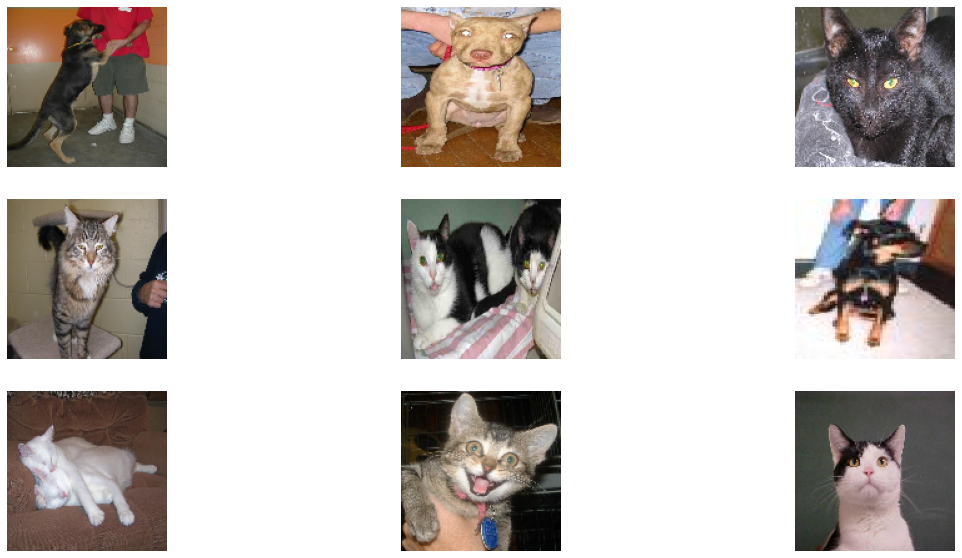

In [21]:
plot_on_grid(test_set, strongly_right_idx)